# Playing Around With Fourier Transforms
We are following https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

In [8]:
# Common imports
import os
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# from numpy.random import seed
# from tensorflow.random import set_seed

# from sklearn import preprocessing
# from keras.layers import Input, Dropout
# from keras.layers.core import Dense 
# from keras.models import Model, Sequential, load_model
# from keras import regularizers
# from keras.models import model_from_json

from scipy.fft import rfft

### My little library of functions

I'll collect all functions at the top so I can copy them into a module easier.

In [2]:
def average_abs_fourier_transform(signal, num_buckets=1024):
    bucket_size = len(signal)//num_buckets
    assert(bucket_size == int(bucket_size))
    # calculate abs and reshape by buckets
    abs_signal = np.abs(signal)
    abs_signal = abs_signal.reshape(num_buckets,bucket_size)
    averaged = abs_signal.mean(axis=1)
    return averaged

In [3]:
def create_bucketed_fourier_transform(raw_data_path, preprocessed_data_path, num_buckets):
    merged_data = pd.DataFrame()
    for ix, filename in enumerate(os.listdir(raw_data_path)):
        dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, filename), sep='\t')
        all_transforms = []
        for i in range(dataset.shape[1]):
            vibrations_over_time = dataset.iloc[:,i]
            fourier_transform = rfft(vibrations_over_time.to_numpy())
            averaged_transform = average_abs_fourier_transform(fourier_transform[:10240],num_buckets=num_buckets)
            all_transforms.append(averaged_transform)
        features = np.concatenate(all_transforms)
        features = pd.DataFrame(features.reshape(1,-1))
        features.index = [filename]
        merged_data = pd.concat([merged_data, features])

    col_names = []
    for i in range(1,dataset.shape[1]+1):
        for j in range(1,num_buckets+1):
            col_names.append(f"Br_{i}_Bu_{j}")
    merged_data.columns = col_names

    merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
    merged_data = merged_data.sort_index()
    outfile = os.path.join(preprocessed_data_path, f'averaged_ft_{num_buckets}_buckets.csv')
    merged_data.to_csv(outfile, index_label = 'timestamp')
    print(f"Dataframe with averaged FT written to {outfile}")
    

### Processing Raw data if preprocessed data does not exist yet.
This file is assumed to be run from train_project_main/notebooks otherwise adapt file paths below.

In [4]:
data_dir = '../data/IMS_bearings'
raw_path_end = 'raw/2nd_test'
prepro_path_end = 'preprocessed/2nd_test'


raw_data_path = os.path.join(data_dir, raw_path_end)
preprocessed_data_path = os.path.join(data_dir, prepro_path_end)

In [5]:
bucket_sizes = [2**i for i in range(4,11)]
for size in bucket_sizes:
    create_bucketed_fourier_transform(raw_data_path,preprocessed_data_path,size)

Dataframe with averaged FT written to ../data/IMS_bearings/preprocessed/2nd_test/averaged_ft_1024_buckets.csv


In [6]:
all_filenames = os.listdir(raw_data_path)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


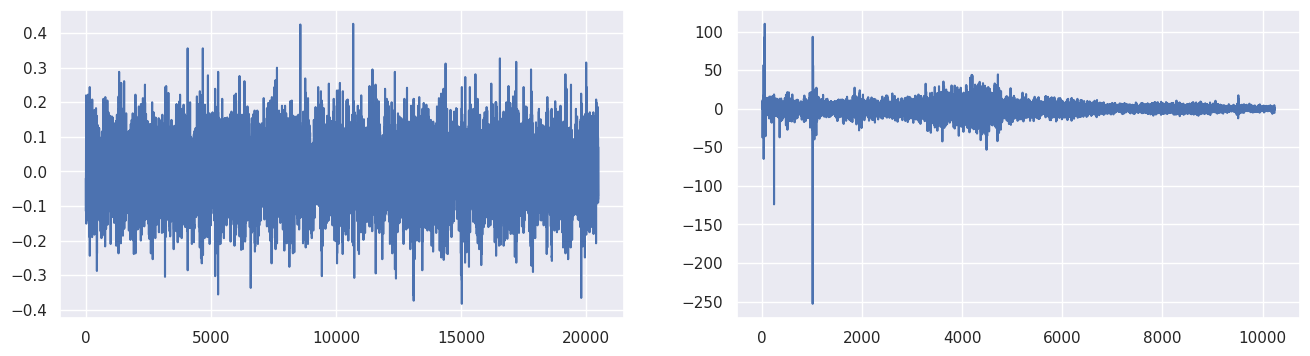

In [9]:
first_file = all_filenames[5]
first_file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, first_file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

In [6]:
num_buckets = 16


all_transforms = []
for i in range(dataset.shape[1]):
    vibrations_over_time = dataset.iloc[:,i]
    fourier_transform = rfft(vibrations_over_time.to_numpy())
    averaged_transform = average_abs_fourier_transform(fourier_transform[:10240],num_buckets=num_buckets)
    all_transforms.append(averaged_transform)
features = np.concatenate(all_transforms)
features = pd.DataFrame(features.reshape(1,-1))
features

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,9.252769,10.813092,11.329292,10.408452,10.962127,20.950465,21.974513,20.507663,8.907066,8.298704,...,11.23767,6.150904,4.308111,3.628675,3.379483,2.854621,2.501906,2.409125,3.147915,2.811335


In [147]:
features

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,9.153549,10.628766,8.447126,8.865767,8.682013,13.629474,16.690194,13.806074,7.131993,7.302518,...,9.943206,5.542185,4.084254,3.670499,3.334229,2.884241,2.451653,2.382187,2.976706,2.731799


In [43]:
abs_fourier_transform = np.abs(fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


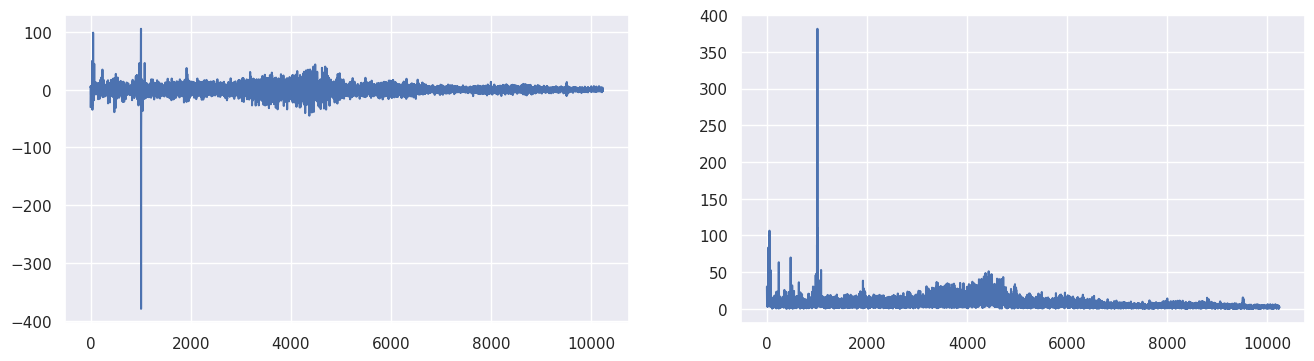

In [44]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(fourier_transform)
axs[1].plot(abs_fourier_transform)

In [50]:
num_points = 10240
bucket_numbers = np.array([2**i for i in range(4,11)])
bucket_size = num_points // bucket_numbers
bucket_design = pd.DataFrame({'num_buckets':bucket_numbers, 'bucket_size':bucket_size})
bucket_design

,num_buckets,bucket_size
0,16,640
1,32,320
2,64,160
3,128,80
4,256,40
5,512,20
6,1024,10


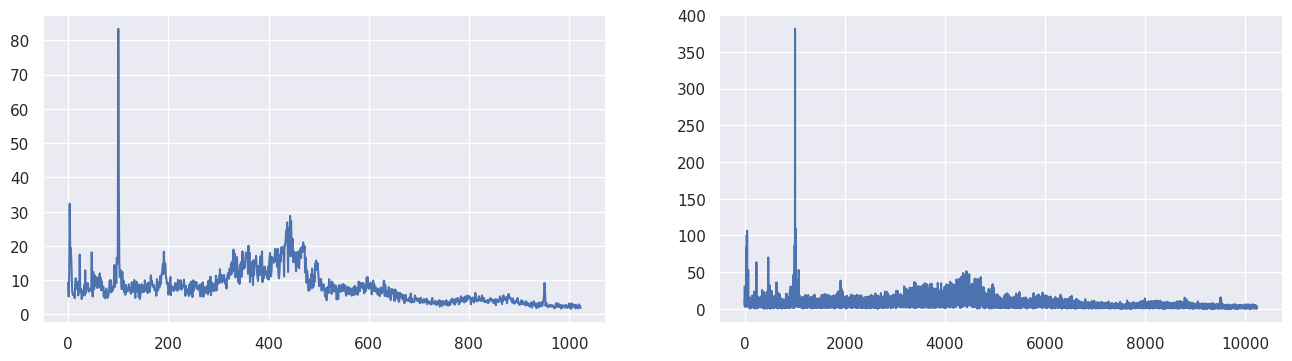

In [73]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(averaged)
axs[1].plot(abs_fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


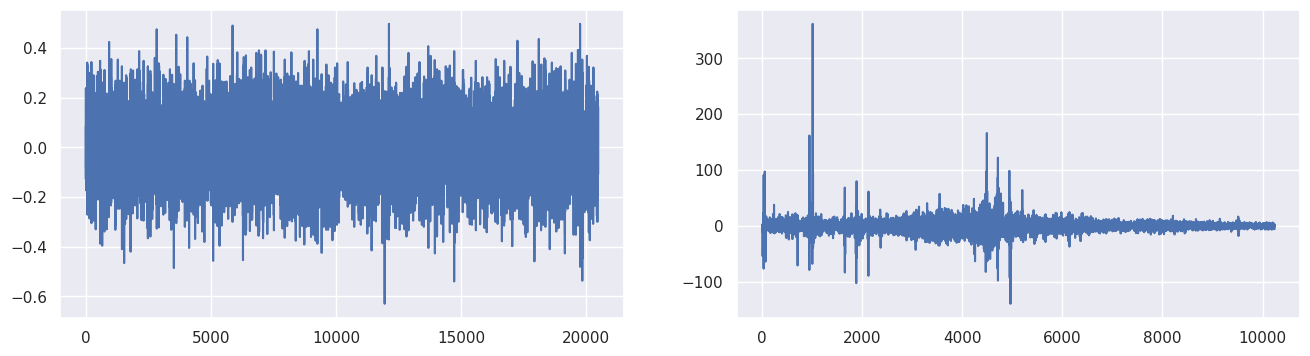

In [29]:
file = all_filenames[500]
file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


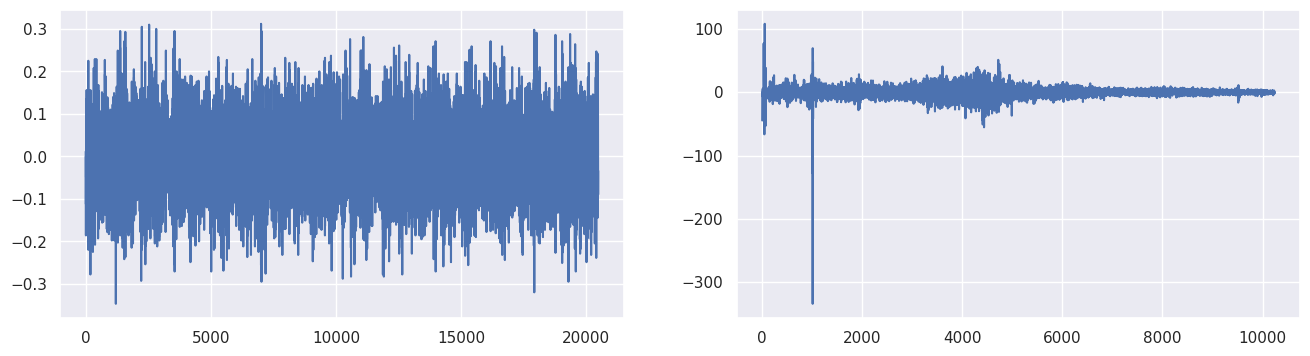

In [34]:
file = all_filenames[600]
file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


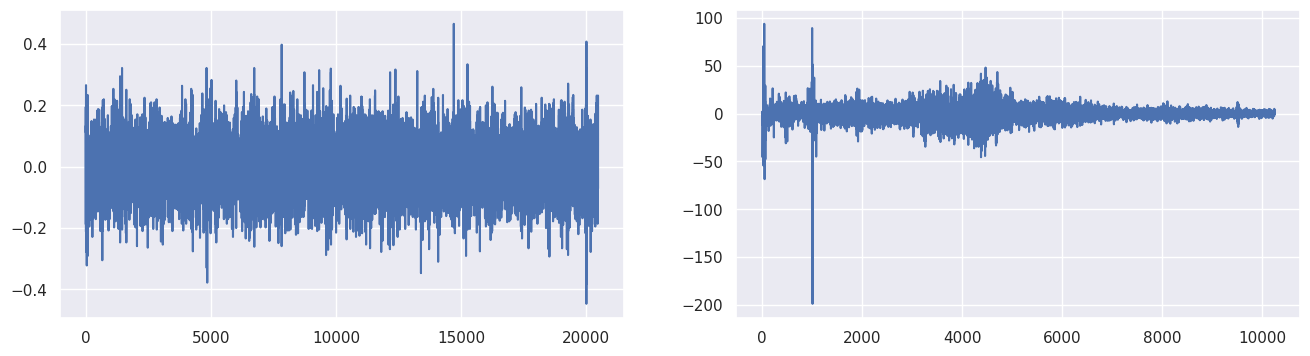

In [35]:
file = all_filenames[700]
file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


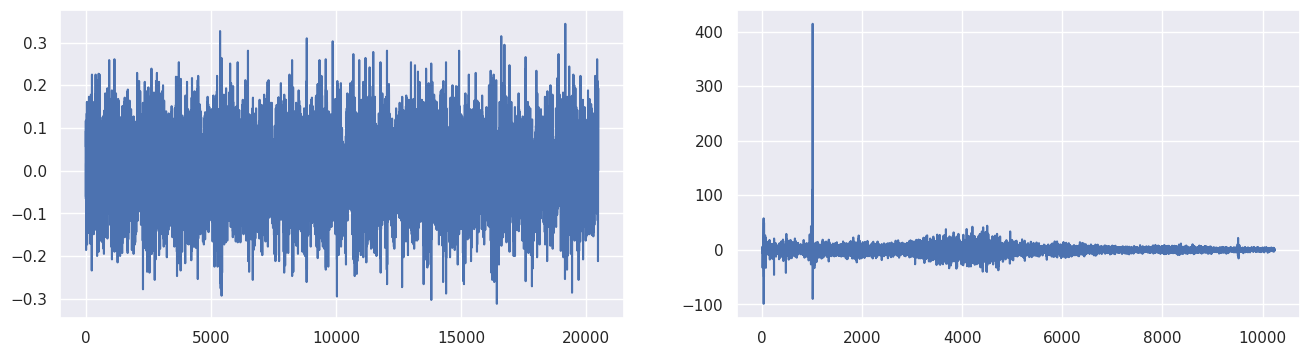

In [36]:
file = all_filenames[800]
file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

/home/julian/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


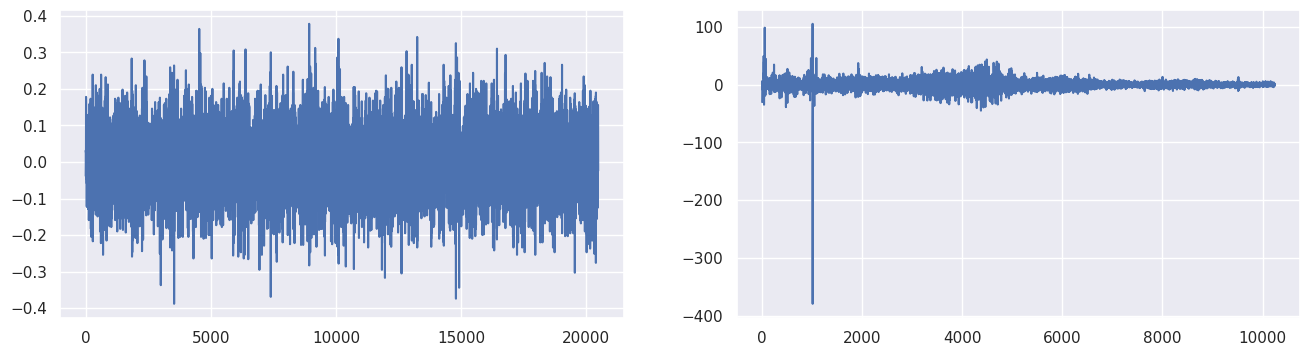

In [37]:
file = all_filenames[900]
file
dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, file), header=None, sep='\t')
first_bearing = dataset.iloc[:,0]
fourier_transform = rfft(first_bearing.to_numpy())
fig, axs = plt.subplots(1,2)
fig.set_size_inches((16,4))
axs[0].plot(first_bearing)
axs[1].plot(fourier_transform)

In [9]:
merged_data = pd.DataFrame()
for filename in os.listdir(os.path.join(data_dir, raw_path_end)):
    #print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, raw_path_end, filename), sep='\t')
    dataset_mean_abs = (dataset.abs().mean()).to_numpy()
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs])

#merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data

,0,1,2,3
2004.02.17.17.52.39,0.085104,0.077032,0.077748,0.049335
2004.02.14.11.42.39,0.060313,0.074149,0.077888,0.044625
2004.02.17.08.52.39,0.121011,0.077503,0.078685,0.051004
2004.02.12.15.02.39,0.061279,0.075562,0.082166,0.044180
2004.02.14.07.32.39,0.060172,0.074794,0.077254,0.044604
...,...,...,...,...
2004.02.13.04.12.39,0.060406,0.075359,0.078920,0.043873
2004.02.17.00.22.39,0.080792,0.074758,0.079311,0.045840
2004.02.14.18.32.39,0.059259,0.074717,0.076415,0.044200
2004.02.17.21.22.39,0.076976,0.078207,0.079763,0.048329


In [4]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv(os.path.join(data_dir, prepro_path_end, 'merged_dataset_BearingTest_2.csv'), 
                   index_label = 'timestamp')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


## Working with the preprocessed data

In [5]:
vibration_mean_df = pd.read_csv(os.path.join(data_dir, prepro_path_end, 'merged_dataset_BearingTest_2.csv'), )
vibration_mean_df.set_index('timestamp', inplace=True)
vibration_mean_df


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
timestamp,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


<AxesSubplot:xlabel='timestamp'>

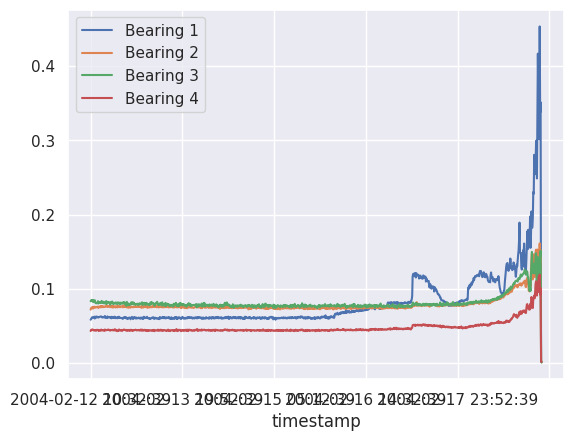

In [6]:
vibration_mean_df.plot()

### Split into "normal" and "mixed" behavior

In [7]:
dataset_train = vibration_mean_df['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = vibration_mean_df['2004-02-13 23:52:39':]

In [8]:
dataset_train.shape, dataset_test.shape 

((222, 4), (760, 4))

<AxesSubplot:xlabel='timestamp'>

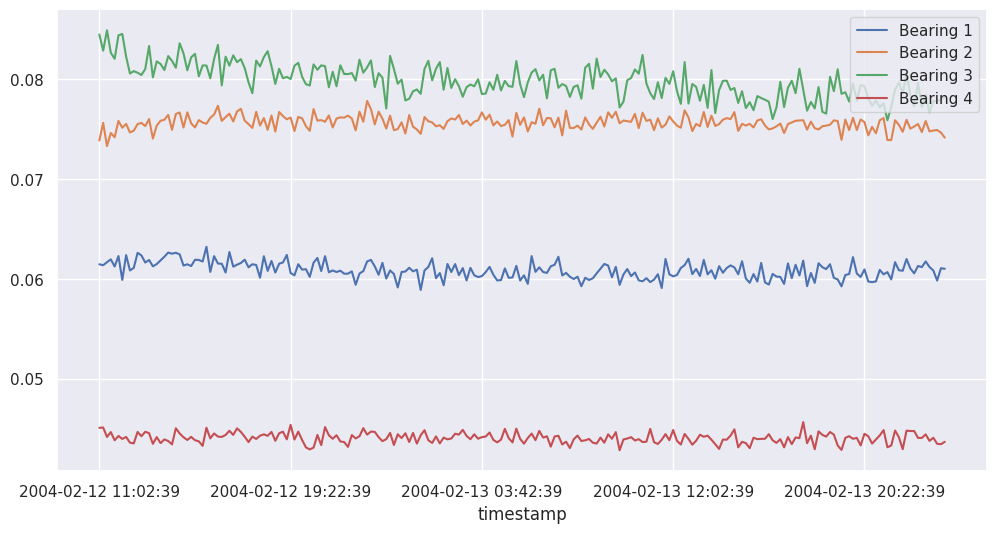

In [9]:
dataset_train.plot(figsize = (12,6))

(0.0, 0.15)

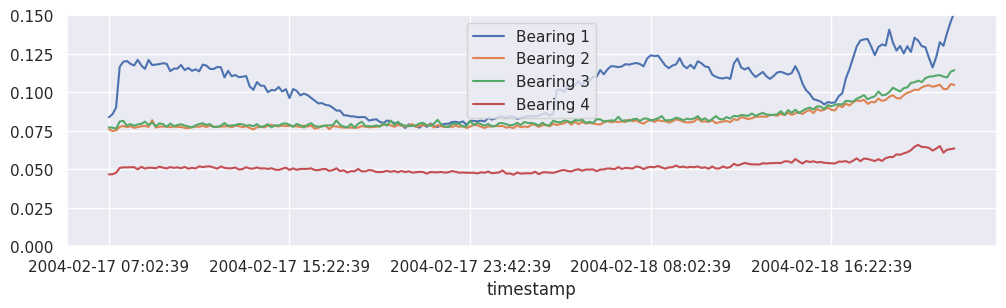

In [10]:
ax = dataset_test.iloc[-285:-50,:].plot(figsize = (12,3))
ax.set_ylim([0,0.15])

(0.0, 0.15)

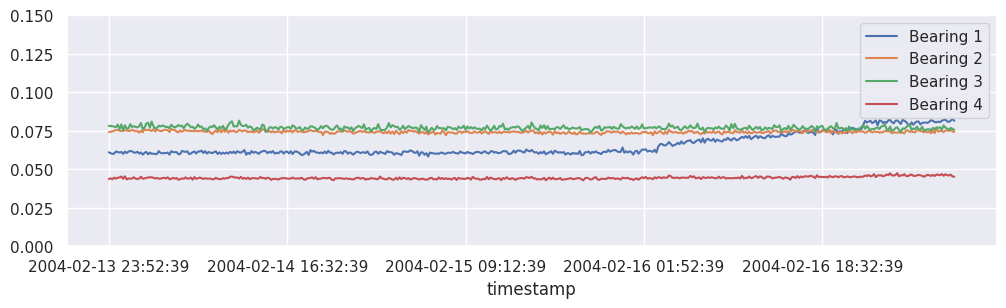

In [11]:
ax = dataset_test.iloc[:-285,:].plot(figsize = (12,3) )
ax.set_ylim([0,0.15])

### Normalize data

In [12]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

X_full = pd.DataFrame(scaler.transform(vibration_mean_df), 
                             columns=dataset_test.columns, 
                             index=vibration_mean_df.index)


In [13]:
X_test.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,760.000000,760.000000,760.000000,760.000000
mean,6.450910,1.353712,0.657615,2.158874
std,10.160072,2.934898,1.457037,3.759362
min,-13.326128,-16.031989,-8.340514,-14.586894
25%,0.522410,0.173830,0.075864,0.438154
50%,3.006861,0.348254,0.206384,0.768482
75%,9.860560,1.093517,0.442492,2.606376
max,91.082874,19.398445,8.371387,27.019529


array([[<AxesSubplot:title={'center':'Bearing 1'}>,
        <AxesSubplot:title={'center':'Bearing 2'}>],
       [<AxesSubplot:title={'center':'Bearing 3'}>,
        <AxesSubplot:title={'center':'Bearing 4'}>]], dtype=object)

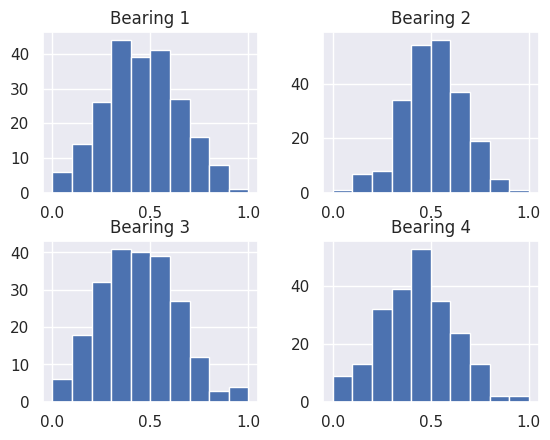

In [14]:
X_train.hist()

## Defining the autoencoder

In [15]:
seed(10)
set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

2024-03-11 17:20:43.238110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-11 17:20:43.238281: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-11 17:20:43.238344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-N2E2EM1P): /proc/driver/nvidia/version does not exist
2024-03-11 17:20:43.239375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10)

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1,
                 callbacks = [es])

Epoch 1/100
21/21 [==============================] - 1s 11ms/step - loss: 0.2195 - val_loss: 0.1121
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1098 - val_loss: 0.0561
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0314
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0293 - val_loss: 0.0266
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0247
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0228
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0215
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0202
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0194
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0197 - val_loss: 0.0188
Epoch 11

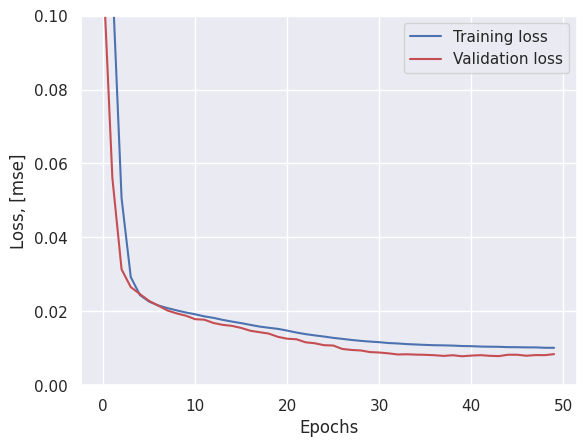

In [18]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

In [19]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)

7/7 [==============================] - 0s 2ms/step


/tmp/ipykernel_217623/197211.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'],


(0.0, 0.5)

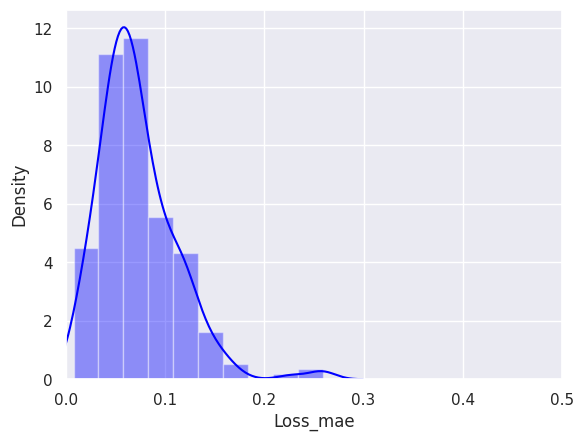

In [20]:
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [23]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.sort_index(inplace=True)
scored

24/24 [==============================] - 0s 1ms/step


,Loss_mae,Threshold,Anomaly
timestamp,,,
2004-02-13 23:52:39,0.110734,0.3,False
2004-02-14 00:02:39,0.067865,0.3,False
2004-02-14 00:12:39,0.032026,0.3,False
2004-02-14 00:22:39,0.027221,0.3,False
2004-02-14 00:32:39,0.118377,0.3,False
...,...,...,...
2004-02-19 05:42:39,27.233694,0.3,True
2004-02-19 05:52:39,17.832209,0.3,True
2004-02-19 06:02:39,19.778811,0.3,True


In [24]:
scored.Anomaly.value_counts()

Anomaly
True     453
False    307
Name: count, dtype: int64

In [25]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored

7/7 [==============================] - 0s 2ms/step


,Loss_mae,Threshold,Anomaly
timestamp,,,
2004-02-12 11:02:39,0.256850,0.3,False
2004-02-12 11:12:39,0.109111,0.3,False
2004-02-12 11:22:39,0.258922,0.3,False
2004-02-12 11:32:39,0.145925,0.3,False
2004-02-12 11:42:39,0.138056,0.3,False
...,...,...,...
2004-02-19 05:42:39,27.233694,0.3,True
2004-02-19 05:52:39,17.832209,0.3,True
2004-02-19 06:02:39,19.778811,0.3,True


In [26]:
scored[scored.Anomaly == True]

,Loss_mae,Threshold,Anomaly
timestamp,,,
2004-02-15 23:52:39,0.332218,0.3,True
2004-02-16 03:12:39,0.376990,0.3,True
2004-02-16 03:22:39,0.478197,0.3,True
2004-02-16 03:32:39,0.590795,0.3,True
2004-02-16 03:42:39,0.519640,0.3,True
...,...,...,...
2004-02-19 05:42:39,27.233694,0.3,True
2004-02-19 05:52:39,17.832209,0.3,True
2004-02-19 06:02:39,19.778811,0.3,True


<AxesSubplot:xlabel='timestamp'>

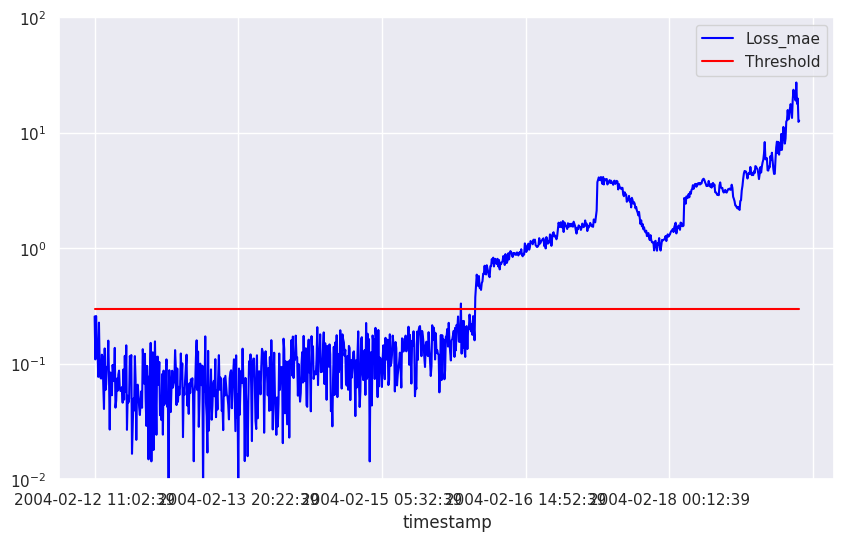

In [27]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

In [28]:
scored

,Loss_mae,Threshold,Anomaly
timestamp,,,
2004-02-12 11:02:39,0.256850,0.3,False
2004-02-12 11:12:39,0.109111,0.3,False
2004-02-12 11:22:39,0.258922,0.3,False
2004-02-12 11:32:39,0.145925,0.3,False
2004-02-12 11:42:39,0.138056,0.3,False
...,...,...,...
2004-02-19 05:42:39,27.233694,0.3,True
2004-02-19 05:52:39,17.832209,0.3,True
2004-02-19 06:02:39,19.778811,0.3,True


In [29]:
scored.to_pickle("data/auto_encoder_prediction_experiment_2.pkl")


# Creating a baseline model based on classic vibration thresholds

Simple idea: 
Train model by observing maximum of mean deviations per bearing. 
Then for each data point: 
    - calculate percentage of max seen so far per bearing and max of that
    - decide on threshold between 1 and infinity to decide on warning

In [30]:
X_full.iloc[0,:].max()

0.8182867547838502

In [31]:
def calculate_relative_vibrations(df):
    
    loss = []
    for i in range(len(df)):
        loss.append(abs(X_full.iloc[i,:].max()))
    return pd.DataFrame({'loss':loss}, index=df.index)
    

In [32]:
relative_vibes = calculate_relative_vibrations(X_full)

In [33]:
relative_vibes.to_pickle("data/classic_thresholding_prediction_experiment_2.pkl")